# Bayesian Bandits and Thompson Sampling

Refer to the follwing medium article https://medium.com/analytics-vidhya/multi-armed-bandit-analysis-of-thompson-sampling-algorithm-6375271f40d1 for a holistic view of Thompson Sampling.

## Thompson sampling with Bernaulli reward

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import beta

In [19]:
# np.random.seed(2)
NUM_TRIALS = 2000
BANDIT_PROBABILITIES = [0.2, 0.5, 0.75]

In [20]:
class Bandit:
    def __init__(self, p):
        self.p = p
        self.a = 1
        self.b = 1
        self.N = 0 # for information only

    def pull(self):
        return np.random.random() < self.p

    def sample(self):
        return np.random.beta(self.a, self.b)

    def update(self, x):
        self.a += x
        self.b += 1 - x
        self.N += 1

In [21]:
def plot(bandits, trial):
    x = np.linspace(0, 1, 200)
    for b in bandits:
        y = beta.pdf(x, b.a, b.b)
        plt.plot(x, y, label=f"real p: {b.p:.4f}, win rate = {b.a - 1}/{b.N}")
    plt.title(f"Bandit distributions after {trial} trials")
    plt.legend()
    plt.show()

In [22]:
def experiment():
    bandits = [Bandit(p) for p in BANDIT_PROBABILITIES]

    sample_points = [5,10,20,50,100,200,500,1000,1500,1999]
    rewards = np.zeros(NUM_TRIALS)
    for i in range(NUM_TRIALS):
    # Thompson sampling
        j = np.argmax([b.sample() for b in bandits])

        # plot the posteriors
        if i in sample_points:
            plot(bandits, i)

        # pull the arm for the bandit with the largest sample
        x = bandits[j].pull()

        # update rewards
        rewards[i] = x

        # update the distribution for the bandit whose arm we just pulled
        bandits[j].update(x)

    # print total reward
    print("total reward earned:", rewards.sum())
    print("overall win rate:", rewards.sum() / NUM_TRIALS)
    print("num times selected each bandit:", [b.N for b in bandits])

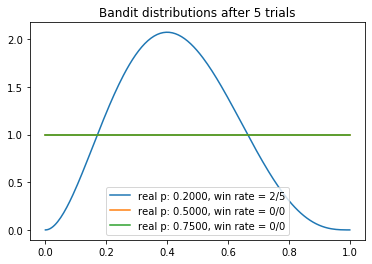

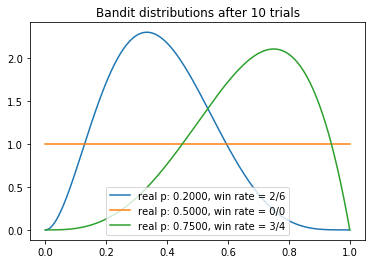

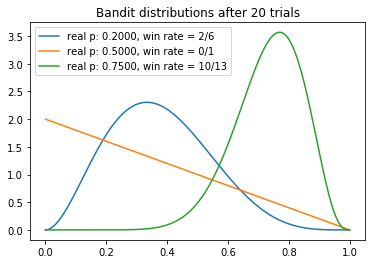

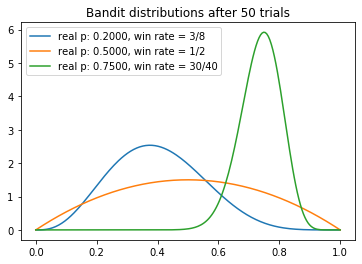

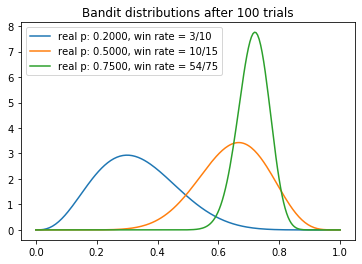

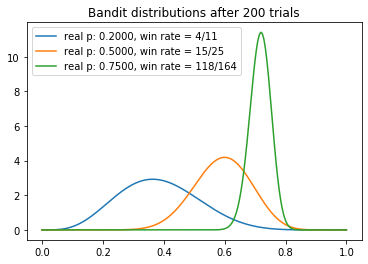

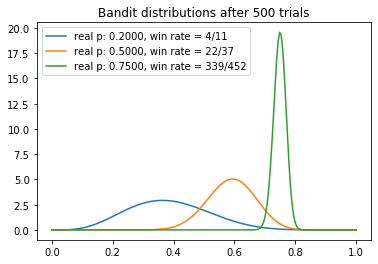

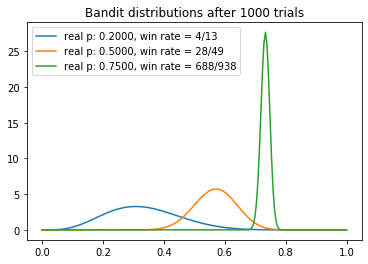

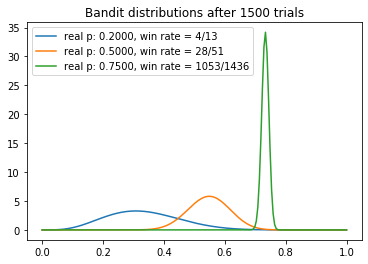

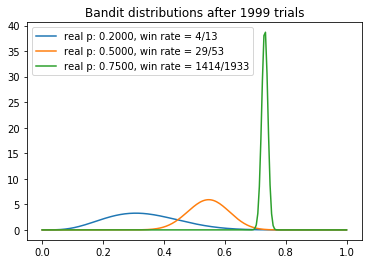

total reward earned: 1448.0
overall win rate: 0.724
num times selected each bandit: [13, 53, 1934]


In [23]:
experiment()

As the number of trials increase, the machine with the highest win rate keeps on getting called more and more which makes the curve thinner and thinner (sample mean being closer to the true mean) which exudes confidence in the algorithm making optimal decisions as the trails increase.

Other curves have a flatter structure which means they called lesser and lesser as the trials increase which is correct given they are suboptimal machines as far the distribution of rewards is concerned. 

## Gaussian Rewards

In [24]:
from scipy.stats import norm

In [25]:
np.random.seed(1)
NUM_TRIALS = 2000
BANDIT_MEANS = [1, 2, 3]

In [26]:
class Bandit:
    def __init__(self, true_mean):
        self.true_mean = true_mean
        # parameters for mu - prior is N(0,1)
        self.m = 0
        self.lambda_ = 1
        self.sum_x = 0 # for convenience
        self.tau = 1
        self.N = 0

    def pull(self):
        return np.random.randn() / np.sqrt(self.tau) + self.true_mean

    def sample(self):
        return np.random.randn() / np.sqrt(self.lambda_) + self.m

    def update(self, x):
        self.lambda_ += self.tau
        self.sum_x += x
        self.m = self.tau*self.sum_x / self.lambda_
        self.N += 1

In [27]:
def plot(bandits, trial):
    x = np.linspace(-3, 6, 200)
    for b in bandits:
        y = norm.pdf(x, b.m, np.sqrt(1. / b.lambda_))
        plt.plot(x, y, label=f"real mean: {b.true_mean:.4f}, num plays: {b.N}")
    plt.title(f"Bandit distributions after {trial} trials")
    plt.legend()
    plt.show()

In [30]:
def run_experiment():
    bandits = [Bandit(m) for m in BANDIT_MEANS]

    sample_points = [5,10,20,50,100,200,500,1000,1500,1999]
    rewards = np.empty(NUM_TRIALS)
    for i in range(NUM_TRIALS):
    # Thompson sampling
        j = np.argmax([b.sample() for b in bandits])

        # plot the posteriors
        if i in sample_points:
            plot(bandits, i)

        # pull the arm for the bandit with the largest sample
        x = bandits[j].pull()

        # update the distribution for the bandit whose arm we just pulled
        bandits[j].update(x)

        # update rewards
        rewards[i] = x

    cumulative_average = np.cumsum(rewards) / (np.arange(NUM_TRIALS) + 1)

    # plot moving average ctr
    plt.plot(cumulative_average)
    for m in BANDIT_MEANS:
        plt.plot(np.ones(NUM_TRIALS)*m)
    plt.show()

    return cumulative_average

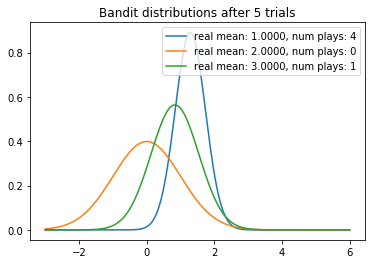

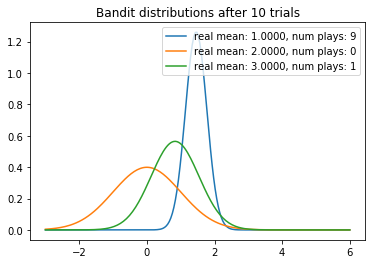

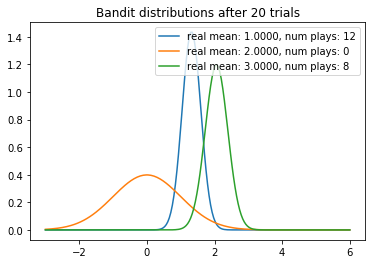

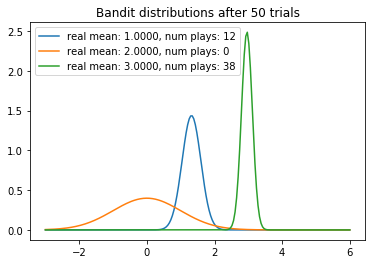

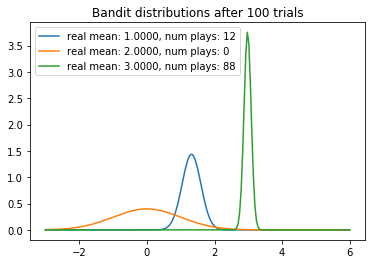

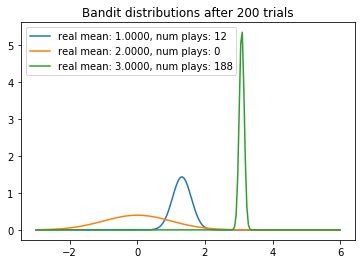

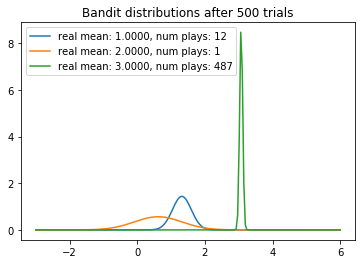

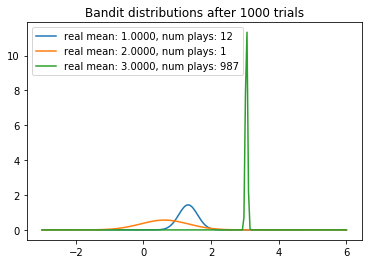

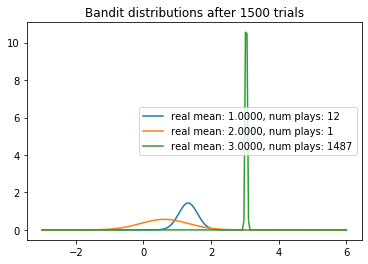

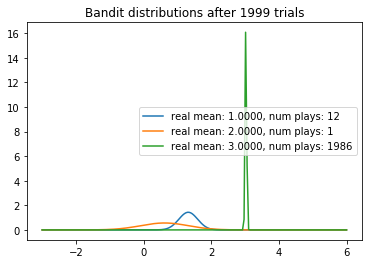

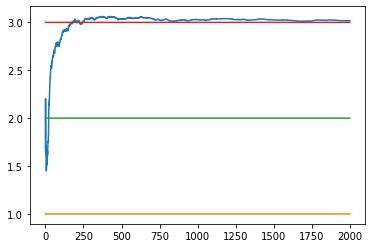

array([1.66557397, 2.20470242, 1.7661049 , ..., 3.01600986, 3.01615703,
       3.01732728])

In [31]:
run_experiment()